In [4]:
import ssl
from typing import Tuple, List
from os.path import join as pj

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

from time import time
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import operator
import nltk
from nltk.corpus import treebank

import conllutils

In [29]:
def get_dataset(file_path: str) -> List[Tuple[str, str]]:
    data = []
    for s in conllutils.read_conllu(file=file_path):
        data.append([(s[i]['form'], s[i]['xpos']) for i in range(len(s)) if not isinstance(s[i]['id'], tuple)])

    return data

In [31]:
train_data = get_dataset(file_path=pj('UD_English-GUM', 'en_gum-ud-train.conllu'))
dev_data = get_dataset(file_path=pj('UD_English-GUM', 'en_gum-ud-train.conllu'))
test_data = get_dataset(file_path=pj('UD_English-GUM', 'en_gum-ud-train.conllu'))

In [46]:
class simple_tagger:

    def get_word_map_and_tag_map(self, data):
        '''
        Input: treebank sentences
        Output:
                word_map - dict with all counters of tags
                tag_map - count tags appearances
        '''
        word_map = {}
        tag_map = {}

        for sentence in data:
            for word, tag in sentence:

                # WORD_MAP
                if word not in word_map:
                    word_map[word] = {}

                if tag in word_map[word]:
                    word_map[word][tag] += 1
                else:
                    word_map[word][tag] = 1

                # TAG_MAP
                if tag not in tag_map:
                    tag_map[tag] = 1
                else:
                    tag_map[tag] += 1
        return word_map, tag_map

    def train(self, data):
        # TODO
        self.map = {}
        self.max_tag = ''

        # use inner function
        word_map, tag_map = self.get_word_map_and_tag_map(data)

        # initilize most frequent tag
        self.max_tag = max(tag_map, key=tag_map.get)

        # initilize map with word and it's own max tag
        for word in word_map:
            tags = word_map[word]
            self.map[word] = max(tags, key=tags.get)

    def evaluate(self, data):
        # TODO
        word_successe = 0
        word_number = 0
        sentence_successe = 0
        sentence_number = len(data)

        for sentence in data:
            word_successe_in_sentence = np.sum([self.map.get(word, self.max_tag) == tag for word, tag in sentence])

            word_number += len(sentence)
            word_successe += word_successe_in_sentence
            sentence_successe += (len(sentence) == word_successe_in_sentence)

        return word_successe / word_number, sentence_successe / sentence_number

    def get_results(self, train_data, test_data):
        r = {}

        r['Training Time'] = time()
        self.train(train_data)
        r['Training Time'] = time() - r['Training Time']

        r['Evaluating Time'] = time()
        r['Word Accuracy'], r['Sentence Accuracy'] = self.evaluate(test_data)
        r['Evaluating Time'] = time() - r['Evaluating Time']

        return r


st = simple_tagger()
results_st = st.get_results(train_data, test_data)
results_st

{'Training Time': 0.04539632797241211,
 'Evaluating Time': 0.015420913696289062,
 'Word Accuracy': 0.8166585060660465,
 'Sentence Accuracy': 0.07685512367491167}

In [48]:
class hmm_tagger:
    def get_word_map_and_tag_map(self, data):
        '''
        Input: treebank sentences
        Output:
                word_map - dict with all counters of tags
                tag_map - count tags appearances
        '''
        word_map = {}
        tag_map = {}

        for sentence in data:
            for word, tag in sentence:

                # WORD_MAP
                if word not in word_map:
                    word_map[word] = {'id': len(word_map), 'tags': {}}

                if tag in word_map[word]['tags']:
                    word_map[word]['tags'][tag] += 1
                else:
                    word_map[word]['tags'][tag] = 1

                # TAG_MAP
                if tag not in tag_map:
                    tag_map[tag] = {'id': len(tag_map), 'count': 1}
                else:
                    tag_map[tag]['count'] += 1

        return word_map, tag_map

    def train(self, data):
        # TODO

        # unique
        word_map, tag_map = self.get_word_map_and_tag_map(data)

        # mapping ID to WORD
        from_id_to_word = {word_map[word]['id']: word for word in word_map.keys()}

        # mapping ID to TAG
        from_id_to_tag = {tag_map[tag]['id']: tag for tag in tag_map}

        # mapping WORD to ID
        from_word_to_id = dict(zip(from_id_to_word.values(), from_id_to_word.keys()))

        # mapping WORD to ID
        from_tag_to_id = dict(zip(from_id_to_tag.values(), from_id_to_tag.keys()))

        # unique tag id
        unique_tag_id = list(from_id_to_tag.keys())

        # create pi
        tag_map_values = np.array([tag['count'] for tag in tag_map.values()])
        pi = tag_map_values / tag_map_values.sum()

        # create B
        B = np.zeros((len(tag_map), len(word_map)))
        for word in word_map.values():
            for tag in word['tags']:
                B[tag_map[tag]['id'], word['id']] = word['tags'][tag]
        B = B / B.sum(axis=1)[:, np.newaxis]

        # create A
        A = np.zeros((len(tag_map), len(tag_map)))
        for sentence in train_data:
            for current_word, next_word in zip(sentence[:-1], sentence[1:]):
                A[tag_map[current_word[1]]['id'], tag_map[next_word[1]]['id']] += 1
        A = A / A.sum(axis=1)[:, np.newaxis]

        # init params
        #         self.word_map = word_map
        #         self.tag_map = tag_map
        #         self.from_id_to_word = from_id_to_word
        #         self.from_id_to_tag = from_id_to_tag
        self.from_word_to_id = from_word_to_id
        self.from_tag_to_id = from_tag_to_id
        self.unique_tag_id = unique_tag_id
        self.A = A
        self.B = B
        self.pi = pi

        # Viterbi

    def viterbi(self, word_list):
        A = self.A
        B = self.B
        Pi = self.pi

        # initialization
        T = len(word_list)
        N = A.shape[0]  # number of tags

        delta_table = np.zeros((N, T))  # initialise delta table
        psi = np.zeros((N, T))  # initialise the best path table

        delta_table[:, 0] = B[:, word_list[0]] * Pi

        for t in range(1, T):
            for s in range(0, N):
                trans_p = delta_table[:, t - 1] * A[:, s]
                psi[s, t], delta_table[s, t] = max(enumerate(trans_p), key=operator.itemgetter(1))
                delta_table[s, t] = delta_table[s, t] * B[s, word_list[t]]

        # Back tracking
        seq = np.zeros(T)
        seq[T - 1] = delta_table[:, T - 1].argmax()
        for t in range(T - 1, 0, -1):
            #       print(seq[t])
            seq[t - 1] = psi[int(seq[t]), t]

        return seq

    def evaluate(self, data):
        # TODO
        word_true = 0
        word_count = 0
        sentence_true = 0

        for sentence in data:

            length = len(sentence)
            tags = np.zeros(length)
            words = np.zeros(length)

            for i, (word, tag) in zip(range(length), sentence):
                words[i] = self.from_word_to_id.get(word, -1)
                tags[i] = self.from_tag_to_id.get(tag, -1)

            split_points = np.where(words == -1)[0]

            # in case there is no -1 in the beginning
            if 0 not in split_points:
                split_points = np.append([0], split_points)

            # in case there is no -1 in the end
            if length not in split_points:
                split_points = np.append(split_points, [length])

            # create pairs of sequences
            sequences = [words[i:j] for i, j in zip(split_points, split_points[1:])]
            result = np.array([])  # I append indtead of gennerate initial randoms which takes time

            # iterate over all sequences
            for seq in sequences:
                if seq[0] == -1:  # there is -1 in seq
                    result = np.append(result, np.random.choice(self.unique_tag_id, size=1))
                    if len(seq[1:]):  # seq is not empty
                        result = np.append(result, self.viterbi(word_list=list(map(int, seq[1:]))))
                else:  # no -1 at all
                    result = np.append(result, self.viterbi(word_list=list(map(int, seq))))

            word_count += length
            word_true += np.sum(result == tags)
            sentence_true += (np.sum(result == tags) == length)

        return word_true / word_count, sentence_true / len(data)

    def get_results(self, train_data, test_data):
        r = {}

        r['Training Time'] = time()
        self.train(train_data)
        r['Training Time'] = time() - r['Training Time']

        r['Evaluating Time'] = time()
        r['Word Accuracy'], r['Sentence Accuracy'] = self.evaluate(test_data)
        r['Evaluating Time'] = time() - r['Evaluating Time']

        return r


hmm = hmm_tagger()
results_hmm = hmm.get_results(train_data, test_data)
results_hmm

{'Training Time': 0.09879159927368164,
 'Evaluating Time': 4.177754163742065,
 'Word Accuracy': 0.7975082966106305,
 'Sentence Accuracy': 0.07773851590106007}

In [45]:
class tnt_tagger:
    def __init__(self):
        from nltk.tag import tnt
        self.tnt_pos_tagger = tnt.TnT()

    def train(self, data):
        self.tnt_pos_tagger.train(data)

    def evaluate(self, data):
        word_true = 0
        word_count = 0
        sentence_true = 0

        for sentence in data:
            length = len(sentence)
            words = [word for word, _ in sentence]
            tags = [tag for _, tag in sentence]

            result = self.tnt_pos_tagger.tag(words)
            sentence_true += (result == sentence)

            results_tag = [tag for _, tag in result]

            word_true += np.sum([r == t for r, t in zip(results_tag, tags)])
            word_count += length

        # Note:
        #         I'm calculating word accuracy by myself.
        #         I could return this: self.tnt_pos_tagger.evaluate(data)
        #         But it will call tag function all over again, so it will do the same thing twice.

        return word_true / word_count, sentence_true / len(data)

    def get_results(self, train_data, test_data):
        r = {}

        r['Training Time'] = time()
        self.train(train_data)
        r['Training Time'] = time() - r['Training Time']

        r['Evaluating Time'] = time()
        r['Word Accuracy'], r['Sentence Accuracy'] = self.evaluate(test_data)
        r['Evaluating Time'] = time() - r['Evaluating Time']

        return r


tnt = tnt_tagger()
results_tnt = tnt.get_results(train_data, test_data)
results_tnt

{'Training Time': 0.3346383571624756,
 'Evaluating Time': 33.99832463264465,
 'Word Accuracy': 0.8054512812142973,
 'Sentence Accuracy': 0.07597173144876325}

In [47]:
rr = tnt.tnt_pos_tagger.evaluate(test_data)
rr

0.8054512812142973

        Training Time  Evaluating Time  Word Accuracy  Sentence Accuracy
simple       0.732759         0.198928       0.874120           0.079869
hmm          1.287485         6.695753       0.864364           0.091904
tnt          0.908800        68.412769       0.875545           0.098468


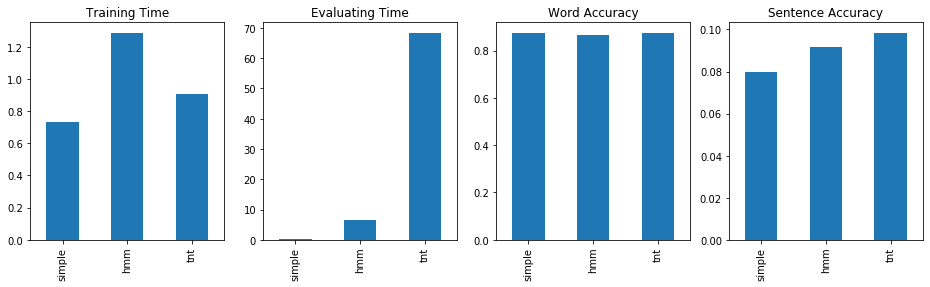

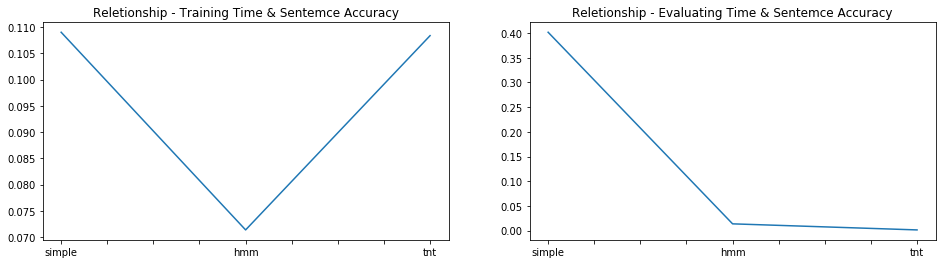

In [12]:
df = pd.DataFrame(columns=results_st.keys())

df.loc['simple'] = results_st
df.loc['hmm'] = results_hmm
df.loc['tnt'] = results_tnt

cols = df.columns
# cols = ['Word Accuracy', 'Sentence Accuracy','Training time', 'Evaluating time']

print(df)

figure, axes = plt.subplots(1, 4, figsize=(16, 4))
for c in range(len(cols)):
    df[cols[c]].plot.bar(title=cols[c], ax=axes[c])
plt.show()

figure, axes = plt.subplots(1, 2, figsize=(16, 4))
(df[cols[3]] / df[cols[0]]).plot(title='Reletionship - Training Time & Sentemce Accuracy', ax=axes[0])
(df[cols[3]] / df[cols[1]]).plot(title='Reletionship - Evaluating Time & Sentemce Accuracy', ax=axes[1])

plt.show()